In [1]:
#coding:utf-8
%reload_ext autoreload 
%autoreload 2
import os
import sys

project_basedir = '..'
sys.path.append(project_basedir)
from cchess_zero import cbf
from cchess_zero import board_visualizer
from matplotlib import pyplot as plt
import os
from cchess_zero.gameboard import *
from net import resnet
import common
from gameplays import gameplay,players
from gameplays.analysis import get_km_json
import json
%matplotlib inline
gpu_core = 6
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_core)

/usr/local/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
!date

2018年 09月 15日 星期六 09:13:17 CST


In [3]:
! ls -l '../data/distributed/' | tail

-rw-rw-r-- 1 meta meta 2341  9月 15 09:13 2018-09-15_09-40-00_621_mcts-mcts_net-net_w.cbf
-rw-rw-r-- 1 meta meta 3366  9月 15 09:13 2018-09-15_09-40-01_345_mcts-mcts_net-net_b.cbf
-rw-rw-r-- 1 meta meta 2241  9月 15 09:13 2018-09-15_09-40-01_582_mcts-mcts_net-net_w.cbf
-rw-rw-r-- 1 meta meta 2191  9月 15 09:13 2018-09-15_09-40-01_976_mcts-mcts_net-net_w.cbf
-rw-rw-r-- 1 meta meta 2366  9月 15 09:13 2018-09-15_09-40-04_300_mcts-mcts_net-net_b.cbf
-rw-rw-r-- 1 meta meta 2716  9月 15 09:13 2018-09-15_09-40-05_852_mcts-mcts_net-net_b.cbf
-rw-rw-r-- 1 meta meta 1666  9月 15 09:13 2018-09-15_09-40-06_684_mcts-mcts_net-net_b.cbf
-rw-rw-r-- 1 meta meta 1966  9月 15 09:13 2018-09-15_09-40-08_740_mcts-mcts_net-net_b.cbf
-rw-rw-r-- 1 meta meta 3391  9月 15 09:13 2018-09-15_09-41-49_174_mcts-mcts_net-net_w.cbf
-rw-rw-r-- 1 meta meta 1791  9月 15 09:13 2018-09-15_09-41-54_937_mcts-mcts_net-net_w.cbf


In [6]:

fullpath = '../data/distributed/2018-09-15_09-29-58_349_mcts-mcts_net-net_b.cbf'
moves = cbf.cbf2move(fullpath)
fname = fullpath.split('/')[-1]
print(fname)
state = gameplay.GameState()

2018-09-15_09-29-58_349_mcts-mcts_net-net_b.cbf


In [7]:
from PIL import Image
import imageio
imgs_for_gif = []
state = gameplay.GameState()
statestr = 'RNBAKABNR/9/1C5C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5c1/9/rnbakabnr'
for i in moves[:-4]: 
    statestr = GameBoard.sim_do_action(i,statestr)
    imgs_for_gif.append(board_visualizer.get_board_img(statestr))
    state.do_move(i)
imgs_for_gif = imgs_for_gif[-20:]
imageio.mimsave('../data/gif/-{}.gif'.format(fname[:-4]), imgs_for_gif,duration=0.5)

In [8]:
i,len(moves)

('h2h7', 19)

In [9]:
def display_gif(fn):
    from IPython import display
    return display.HTML('<img src="{}">'.format(fn))

In [10]:
display_gif('../data/gif/-{}.gif'.format(fname[:-4]))

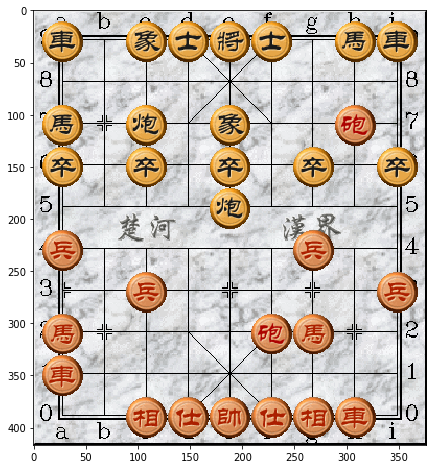

In [11]:
plt.figure(figsize=(8,8))
plt.imshow(board_visualizer.get_board_img(statestr))

# ANALYSIS

In [12]:
network = resnet.get_model(os.path.join(project_basedir,
    '../data/prepare_weight/2018-09-15_08-00-25_noup'[3:]),
    common.board.create_uci_labels(),GPU_CORE=[gpu_core],FILTERS=128,NUM_RES_LAYERS=7)

0
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
inside res net [None, 10, 9, 128]
INFO:tensorflow:Restoring parameters from ../data/prepare_weight/2018-09-15_08-00-25_noup


In [13]:
network_player = players.NetworkPlayer(state.currentplayer,network,n_playout=1)

In [14]:
network_player.make_move(state=state,actual_move=False)

('f9e8', 0.179373100399971)

In [15]:
network_player.mcts_policy._root._Q

-0.179373100399971

In [16]:
childs = network_player.mcts_policy._root._children
probs = []
for move in childs:
    val = childs[move]
    print(move,val._n_visits,val._P,val._Q)
    probs.append(val._P)

a9b9 0 0.16270451 0
a9a8 0 0.011927268 0
a7b9 0 0.008978839 0
a7c8 0 0.0022653886 0
a6a5 0 0.014941138 0
c7b7 0 0.010159571 0
c7d7 0 0.014769604 0
c7h7 0 0.0033585117 0
c7c8 0 0.0148833 0
c7c3 0 0.0015257956 0
c6c5 0 0.0065618525 0
e9e8 0 0.0044864686 0
e5a5 0 0.00041166772 0
e5b5 0 0.0006515393 0
e5c5 0 0.0012207488 0
e5d5 0 0.001778307 0
e5f5 0 0.0021352775 0
e5g5 0 0.002929332 0
e5h5 0 0.0011859026 0
e5i5 0 0.0015666452 0
e5e4 0 0.0062786923 0
e5e3 0 0.0031960644 0
e5e2 0 0.0018788335 0
e5e1 0 0.00036542275 0
g6g5 0 0.017495252 0
h9f8 0 0.28896958 0
h9g7 0 0.15210673 0
h9i7 0 0.15764013 0
i9i8 0 0.005843054 0
i9i7 0 0.026286863 0
i6i5 0 0.0077176443 0
d9e8 0 0.017046254 0
f9e8 0 0.020099059 0
e7g5 0 0.0026487464 0
e7c5 0 0.0021508255 0
e7g9 0 0.00339977 0


In [18]:
datajson = get_km_json(network_player.mcts_policy,state.statestr,depth=40)

In [629]:
!mkdir '../data/mstc_vis'

mkdir: 无法创建目录"../data/mstc_vis": 文件已存在


In [630]:
with open('../data/mstc_vis/sample.km','w') as whdl:
    json.dump(datajson,whdl)